# Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials

#### This notebook serves as a compilation of useful concepts I picked out from tutorial 1-3 and contains some of my observations and findings from experimenting with exercises given in the original notebooks, which might come in handy for future reference.

# Summary on tensorflow's performance:

With just 10 iteration, accuracy of the model rapidly increases to almost 70% from the initial 9%.
With further training of 990 more iterations, accuracy has increased to 90+%.
However, the model would still classify some input which are very obvious to the human eye wrongly.
Upon further inspection, the weights for 1000 iteration is more distorted than 10 iterations but yet has higher accuracy.
This is surprising and begs the question of whether the model has actually learned the classification well.

Repeated experiment with batch size = 1000 gave similar pattern. However the initial improvement between 1 and 10 iterations are much more drastic. It increases to 80+%, which is a lot better compared to using batch size 100.

Repeated experiment using batch size = 1 gave horrendous results. Accuracy improvement was low compared to the two above.
What's more shocking is the conflicting and distorted weights, which suggests that the model appears "confused".

# Summary on keras:

Generally, training takes longer time than using tensorflow. Possibly because it is a convolutional neural network and has a more complex computational graph.

Accuracy for sequential model is of 98+% is very high. However, the model seems to have trouble classifying the number 8 correctly. It misclassified them as 2, 4 and 0 occasionally. Perhaps the parts of the 8's structure look like it's can be formed by gluing together parts of other numbers.

The accuracy of the more complex functional model is roughly the same at 98+%. It also faces similar problem for the number 2. 
It also have trouble differentiating between 0 and 6. For that, I give it the benefit of doubt since humans are also prone to making that mistake especially when the handwritting is bad.

Experimenting with epoch = 4:
This means iterating over the entire dataset 4 times. Slight increase in accuracy from 98.2% to 98.7% for sequential model, and 99.1% on functional model. For a slight improvement, a lot more time is required to train the models. Whether this is worth it depends on whether you have time.

Experimenting with stride for maxpooling = 3: Both models accuracy dropped slightly to around 97%. 
Experimenting with stride for maxpooling = 5: Sequential model's accuracy dropped to 91.2% while Functional model's accuracy dropped to 88.6%.
Experimenting with stride for convolutional layers = 4:
As observed, the increase in stride might cause sampled images to miss out on certain pixels, there is more uncertainty involved in doing so. It seems that functional model is affected much more by this. 


Overall, these gave me some insights on how certain parameters can affect the results and their significance.
Use of hyper-parameter tuning covered in later parts of tutorial might be useful in producing the optimal model.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

from sklearn.metrics import confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


## Helper function

In [2]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
# Plots images that have been misclassified
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_example_errors_tensorflow():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Test-set:		10000


In [5]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = data.img_shape_full

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

## Plotting the first 10 images with their true classification

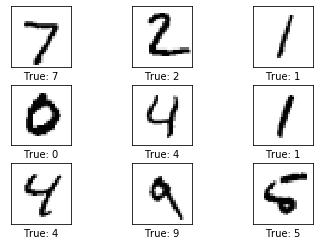

In [6]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Tensorflow linear model

### Placeholder variables

Holds our input and output

In [7]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

The target function we want to learn are weights that can produce the correct classifications.

In [8]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [9]:
# logits is a conventional name for our model.
logits = tf.matmul(x, weights) + biases

In [10]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost function measured using entropy

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization method

In [12]:
# we have chosen to experiment with gradient descent optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance measure

In [13]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running the model we created

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Optimizing our model

In [15]:
# 1, 100 or 1000
batch_size = 100

def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Comparing performances based on iterations of optimization

In [16]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

Accuracy on test-set: 9.8%


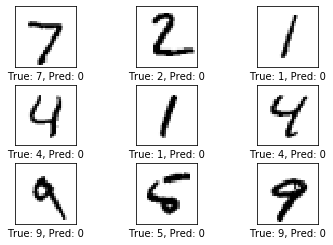

In [17]:
# Initial accuracy
print_accuracy()
plot_example_errors_tensorflow()

Accuracy on test-set: 75.2%


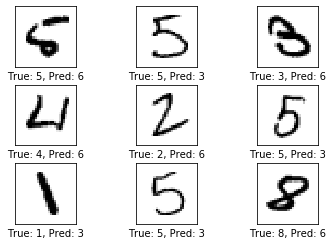

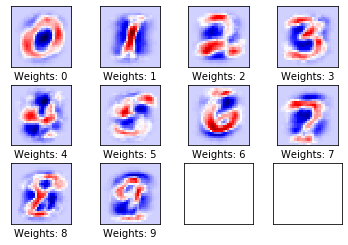

In [18]:
# Performance after 10 iterations
optimize(num_iterations=10)
print_accuracy()
plot_example_errors_tensorflow()
plot_weights()

Accuracy on test-set: 91.7%


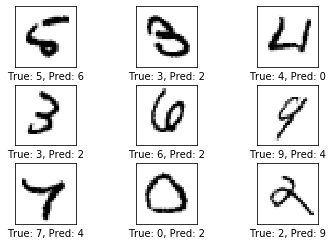

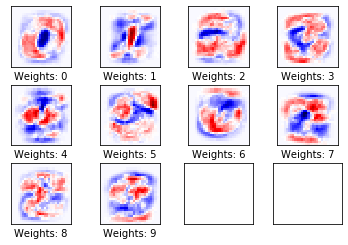

In [19]:
# Performance after 1000 iterations, including previous iterations
optimize(num_iterations=990)
print_accuracy()
plot_example_errors_tensorflow()
plot_weights()

[[ 960    0    7    2    0    3    5    1    2    0]
 [   0 1111    2    2    0    2    4    2   12    0]
 [   6    7  948   12   11    1   10   10   22    5]
 [   3    1   30  920    0   18    2   11   19    6]
 [   2    4   12    1  908    0    7    4   10   34]
 [  10    3   13   45    6  753    8    8   39    7]
 [  15    3   16    1   10   24  885    1    3    0]
 [   4   11   31    7    5    0    0  950    2   18]
 [   7   10   15   31    9   23    8   13  853    5]
 [  12    8    5   10   36    7    0   41    8  882]]


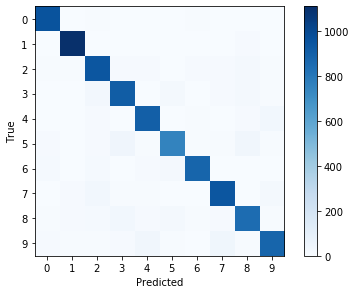

In [20]:
# Can be used to see what is commonly classified wrongly
print_confusion_matrix()

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

Tutorial 2 shows implementation of CNN using tensorflow. Keras is much preferred by the original author himself.
Doing CNN using keras uses shorter codes.

List of proven implementations @ https://github.com/keras-team/keras/tree/master/examples.

Refer to https://www.tensorflow.org/guide/keras.

In [21]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate.

In [22]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [23]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.

In [24]:
model.fit(x=data.x_train,
          y=data.y_train,
          epochs=1, batch_size=128)

Train on 55000 samples
55000/55000 [==============================] - 26s 467us/sample - loss: 0.2192 - acc: 0.9342


### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [25]:
result = model.evaluate(x=data.x_test,
                        y=data.y_test)

10000/10000 [==============================] - 1s 139us/sample - loss: 0.0633 - acc: 0.9775


We can print all the performance metrics for the test-set.

In [26]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06327831935090944
acc 0.9775


Or we can just print the classification accuracy.

In [27]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 97.75%


### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [28]:
images = data.x_test[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [29]:
cls_true = data.y_test_cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [30]:
y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [31]:
cls_pred = np.argmax(y_pred, axis=1)

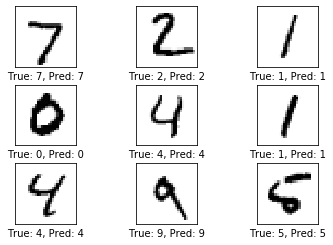

In [32]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [33]:
y_pred = model.predict(x=data.x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [34]:
cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

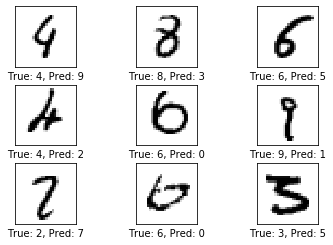

In [35]:
plot_example_errors(cls_pred)

## Functional Model

A more complex models that allows for building more complex computational graph.

In [36]:
# Create an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the Neural Network.
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(img_shape_full)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128, activation='relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes, activation='softmax')(net)

# Output of the Neural Network.
outputs = net

### Model Compilation

We have now defined the architecture of the model with its input and output. We now have to create a Keras model and compile it with a loss-function and optimizer, so it is ready for training.

In [37]:
from tensorflow.python.keras.models import Model

Create a new instance of the Keras Functional Model. We give it the inputs and outputs of the Convolutional Neural Network that we constructed above.

In [38]:
model2 = Model(inputs=inputs, outputs=outputs)

Compile the Keras model using the RMSprop optimizer and with a loss-function for multiple categories. The only performance metric we are interested in is the classification accuracy, but you could use a list of metrics here.

In [39]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Training

The model has now been defined and compiled so it can be trained using the same `fit()` function as used in the Sequential Model above. This also takes numpy-arrays as input.

In [40]:
model2.fit(x=data.x_train,
           y=data.y_train,
           epochs=1, batch_size=128)

Train on 55000 samples
55000/55000 [==============================] - 26s 471us/sample - loss: 0.1988 - acc: 0.9378


### Evaluation

Once the model has been trained we can evaluate its performance on the test-set. This is the same syntax as for the Sequential Model.

In [41]:
result = model2.evaluate(x=data.x_test,
                         y=data.y_test)

10000/10000 [==============================] - 2s 154us/sample - loss: 0.0657 - acc: 0.9795


The result is a list of values, containing the loss-value and all the metrics we defined when we compiled the model. Note that 'accuracy' is now called 'acc' which is a small inconsistency.

In [42]:
for name, value in zip(model2.metrics_names, result):
    print(name, value)

loss 0.06573536654412747
acc 0.9795


We can also print the classification accuracy as a percentage:

In [43]:
print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

acc: 97.95%


### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [44]:
y_pred = model2.predict(x=data.x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [45]:
cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

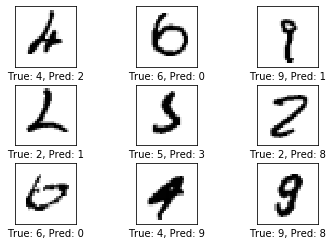

In [46]:
plot_example_errors(cls_pred)

## Visualization of Layer Weights and Outputs

In [47]:
# listing the layers of 
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0     

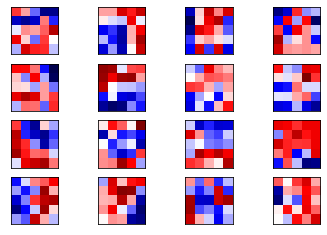

In [48]:
layer_input = model2.layers[0]
layer_conv1 = model2.layers[2]
layer_conv2 = model2.layers[4]
# weights for layer 1
weights_conv1 = layer_conv1.get_weights()[0] # a 4 rank tensor
plot_conv_weights(weights=weights_conv1, input_channel=0)

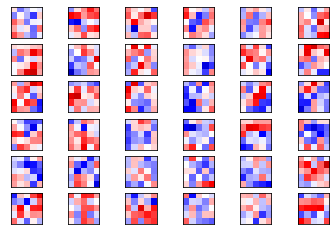

In [49]:
# weights for layer 2
weights_conv2 = layer_conv2.get_weights()[0]
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Output of layers

In [50]:
from tensorflow.python.keras import backend as K

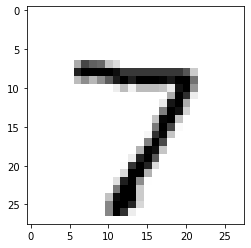

In [51]:
image1 = data.x_test[0]
plot_image(image1)

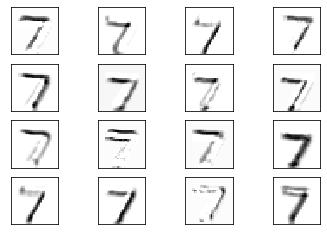

In [52]:
output_conv1 = Model(inputs=layer_input.input,
                     outputs=layer_conv1.output)
layer_output1 = output_conv1.predict(np.array([image1]))
plot_conv_output(values=layer_output1)

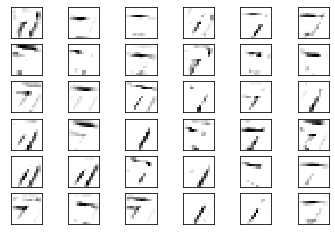

In [53]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)
layer_output2 = output_conv2.predict(np.array([image1]))
plot_conv_output(values=layer_output2)

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.